# 8 group simulations

This notebook runs simulations of COVID spread by modeling 8 different demographic groups defined by the Cornell group (documented <a href="https://docs.google.com/document/d/1gBoRecBRAbyONU7CgDV_rzkCVmrJJbTkSP2TpVBNl8g/edit">here</a>). Parameterization of the individual models of this group are described <a href="https://docs.google.com/document/d/1dPm0BvstSPbDc5gnpYDx6c-aUaySSq62IjIrH_rmbhw/edit?ts=5f3e8b7f">here</a>. Values for the interaction matrix (# of contacts between groups per day) are from the Cornell parameterization (also described in the first document linked above).

In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [2]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [3]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    list_dfs = list()
    for sim_group in sim.sims:
        list_dfs.append(sim_group.sim_df)
    return list_dfs

def run_multiple_trajectories(sim, T, n):
    sim_results = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        sim_results.append(result)
    return sim_results

In [22]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    sim_results = run_multiple_trajectories(sim, T, n)
    return tests_per_day, sim_results

In [5]:
# uw testing policy - see https://docs.google.com/document/d/1dPm0BvstSPbDc5gnpYDx6c-aUaySSq62IjIrH_rmbhw/edit
policy = [0.07142857143, 0.002945022323, 0.002987018418, 0.002987018418, 0.002987018418, 0.002987018418, 0, 0]

In [6]:
# Not currently used in UW simulations...

base_directory = '../src/simulations_v2/params/baseline_testing/uw_groups/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]

ug_high_tests_per_day = ug_dorm_params['population_size'] * policy[0]

student_tests_per_day = 0
student_tests_per_day += ug_dorm_params['population_size'] * policy[0]
student_tests_per_day += ug_off_campus_params['population_size'] * policy[1]
student_tests_per_day += gs_research_params['population_size'] * policy[2]
student_tests_per_day += gs_other_params['population_size'] * policy[3]
ug_high_tests_per_day, student_tests_per_day

/Users/stevewangen/projects/COVID/uw_reopening/src/simulations_v2/load_params.py:132: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/Users/stevewangen/projects/COVID/uw_reopening/src/simulations_v2/load_params.py:46: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


(495.07142858133005, 608.7125442865481)

# Running simulations

Three simulations to compare the initial prevelence values obtained from three different sources. All other variables are kept constant.

In [75]:
# IM from cornell

interaction_matrix = np.array([[12.5,  4,     0.1,   0.1,   1,     0.05,  0.05, 0.1],
                               [3.41,  8,     0.1,   0.1,   1,     0.05,  0.05, 0.2],
                               [0.19,  0.22,  4,     0.1,   1.2,   0.05,  0.2,  1.8],
                               [0.14,  0.17,  0.07,  9,     1,    0.05,   0.05, 0.2],
                               [1.92,  2.26,  1.22,  1.37,  1,     0.15,  0.3,  1.56],
                               [0.18,  0.21,  0.1,   0.13,  0.28,  1.8,   0.2,  1.56],
                               [0.07,  0.09,  0.15,  0.05,  0.23,  0.08,  1.8,  1.56],
                               [0.011, 0.026, 0.106, 0.016, 0.091, 0.048, 0.12, 3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [40]:
# experiment

interaction_matrix = np.array([[8.2,   4,     0.1,   0.1,      1,   0.05, 0.05, 0.1],
                               [3.41,  8.2,   0.1,   0.1,      1,   0.05, 0.05, 0.2],
                               [0.19,  0.22,  4,     0.1,    1.2,   0.05,  0.2, 1.8],
                               [0.14,  0.17,  0.07,  8.2,      1,   0.05, 0.05, 0.2],
                               [1.92,  2.26,  1.22,  1.37,     1,   0.15,  0.3, 1.56],
                               [0.18,  0.21,  0.1,   0.13,  0.28,    1.8,  0.2, 1.56],
                               [0.07,  0.09,  0.15,  0.05,  0.23,   0.08,  1.8, 1.56],
                               [0.011, 0.026, 0.106, 0.016, 0.091, 0.048, 0.12, 3.5]])


In [76]:
group_sizes = [6931, 24254, 13012, 1120, 1698, 8083, 8084, 258054]

In [77]:
# rescale interaction matrix based on UW group sizes

for i in range(8):
    for j in range(8):
        interaction_matrix[j, i] = (interaction_matrix[i, j] * group_sizes[i]) / group_sizes[j]

In [78]:
from pandas import DataFrame
print(DataFrame(interaction_matrix))

           0          1         2         3         4         5        6     7
0  12.500000   4.000000  0.100000  0.100000  1.000000  0.050000  0.05000  0.10
1   1.143069   8.000000  0.100000  0.100000  1.000000  0.050000  0.05000  0.20
2   0.053266   0.186397  4.000000  0.100000  1.200000  0.050000  0.20000  1.80
3   0.618839   2.165536  1.161786  9.000000  1.000000  0.050000  0.05000  0.20
4   4.081861  14.283863  9.195760  0.659600  1.000000  0.150000  0.30000  1.56
5   0.042874   0.150031  0.080490  0.006928  0.031511  1.800000  0.20000  1.56
6   0.042869   0.150012  0.321920  0.006927  0.063013  0.199975  1.80000  1.56
7   0.002686   0.018798  0.090762  0.000868  0.010265  0.048864  0.04887  3.50


In [59]:
4 * 6920 / 8213

3.3702666504322414

In [60]:
3.42 * 8213 / 6920

4.059026011560693

## Nominal

In [61]:
base_directory = '../src/simulations_v2/params/baseline_testing/uw_groups/nominal/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'madison_community.yaml')[1]

/Users/stevewangen/projects/COVID/uw_reopening/src/simulations_v2/load_params.py:132: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/Users/stevewangen/projects/COVID/uw_reopening/src/simulations_v2/load_params.py:46: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [62]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day_nominal, sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 50)

In [74]:
tests_per_day_nominal

637.9285714330061

## Optimistic

In [63]:
base_directory = '../src/simulations_v2/params/baseline_testing/uw_groups/optimistic/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'madison_community.yaml')[1]

In [64]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day_optimistic, sim_results_optimistic = evaluate_testing_policy(params_list, 0.7*interaction_matrix, group_names, policy, 112, 50)
# tests_per_day_optimistic, sim_results_optimistic = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 50)

## Pessimistic 

In [65]:
base_directory = '../src/simulations_v2/params/baseline_testing/uw_groups/pessimistic/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'madison_community.yaml')[1]

In [66]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day_pessimistic, sim_results_pessimistic = evaluate_testing_policy(params_list, 1.3*interaction_matrix, group_names, policy, 112, 50)
# tests_per_day_pessimistic, sim_results_pessimistic = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 50)

### Exporting optimistic, nominal, pessimistic sim results 

In [14]:
import dill
with open('uw_init_prev_results_optimistic.dill', 'wb') as file:
    dill.dump(sim_results_optimistic, file)
    file.close()
with open('uw_init_prev_results_nominal.dill', 'wb') as file:
    dill.dump(sim_results_nominal, file)
    file.close()
with open('uw_init_prev_results_pessimistic.dill', 'wb') as file:
    dill.dump(sim_results_pessimistic, file)
    file.close()

### Importing sim results from pickles

In [15]:
with open('uw_init_prev_results_optimistic.dill', 'rb') as file:
    sim_results_optimistic = dill.load(file)
    file.close()
with open('uw_init_prev_results_nominal.dill', 'rb') as file:
    sim_results_nominal = dill.load(file)
    file.close()
with open('uw_init_prev_results_pessimistic.dill', 'rb') as file:
    sim_results_pessimistic = dill.load(file)
    file.close()

# Visualizing results

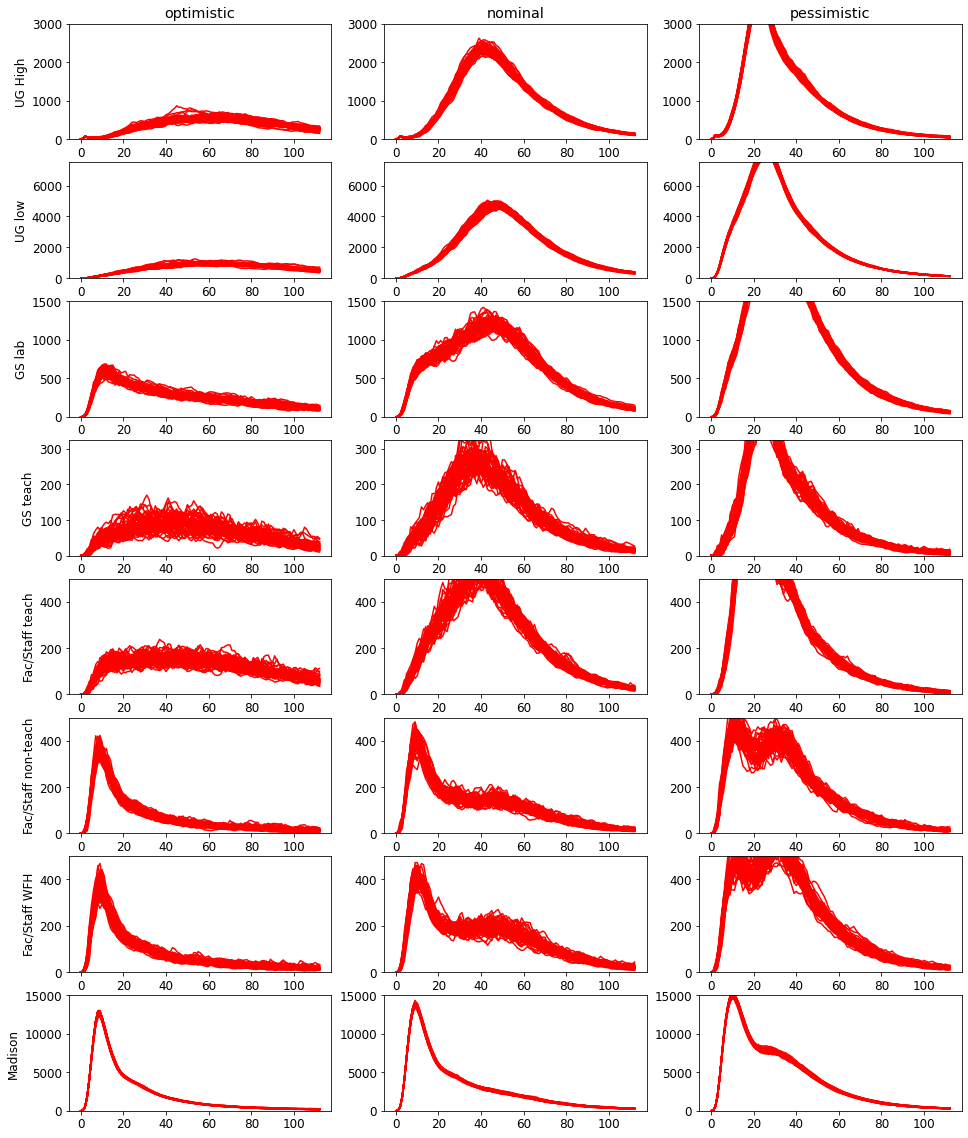

In [67]:
# Figuring out plotting w/ total quarentined individuals (QI + QS)

scen_names = ['optimistic', 'nominal', 'pessimistic']
group_names = ['UG High', 'UG low', 'GS lab', 'GS teach', 'Fac/Staff teach', 'Fac/Staff non-teach', 'Fac/Staff WFH', 'Madison']
ylim_max = [3000, 7500, 1500, 325, 500, 500, 500, 15000]
fig, axs = plt.subplots(8, 3, figsize=(16,20))
# plt.ylim(0, 25000)

# fill w/ results
all_results = [sim_results_optimistic, sim_results_nominal, sim_results_pessimistic]
for scenario in range(3):
    for results in all_results[scenario]:
        for group in range(8):
            axs[group, scenario].set_ylim(0, ylim_max[group])
            axs[group, scenario].plot(results[group]['QS']+results[group]['QI'], color='red')
            if group == 0:
                axs[group, scenario].set_title(scen_names[scenario])
            if scenario == 0:
                axs[group, scenario].set(ylabel=group_names[group])
                
# fig.suptitle('Total quarantined per group')

In [37]:
from deprecated.params import ParamConfig

# Massey's suggestion (but syntax looks different)
# from load_params import load_params

base_params = ParamConfig.load_config('fall', True, 'nominal')
params = base_params.copy()

In [38]:
# define groups
active_cols = ['QI'] + ['E_{}'.format(x) for x in range(params['max_time_exposed'])] + \
                ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]

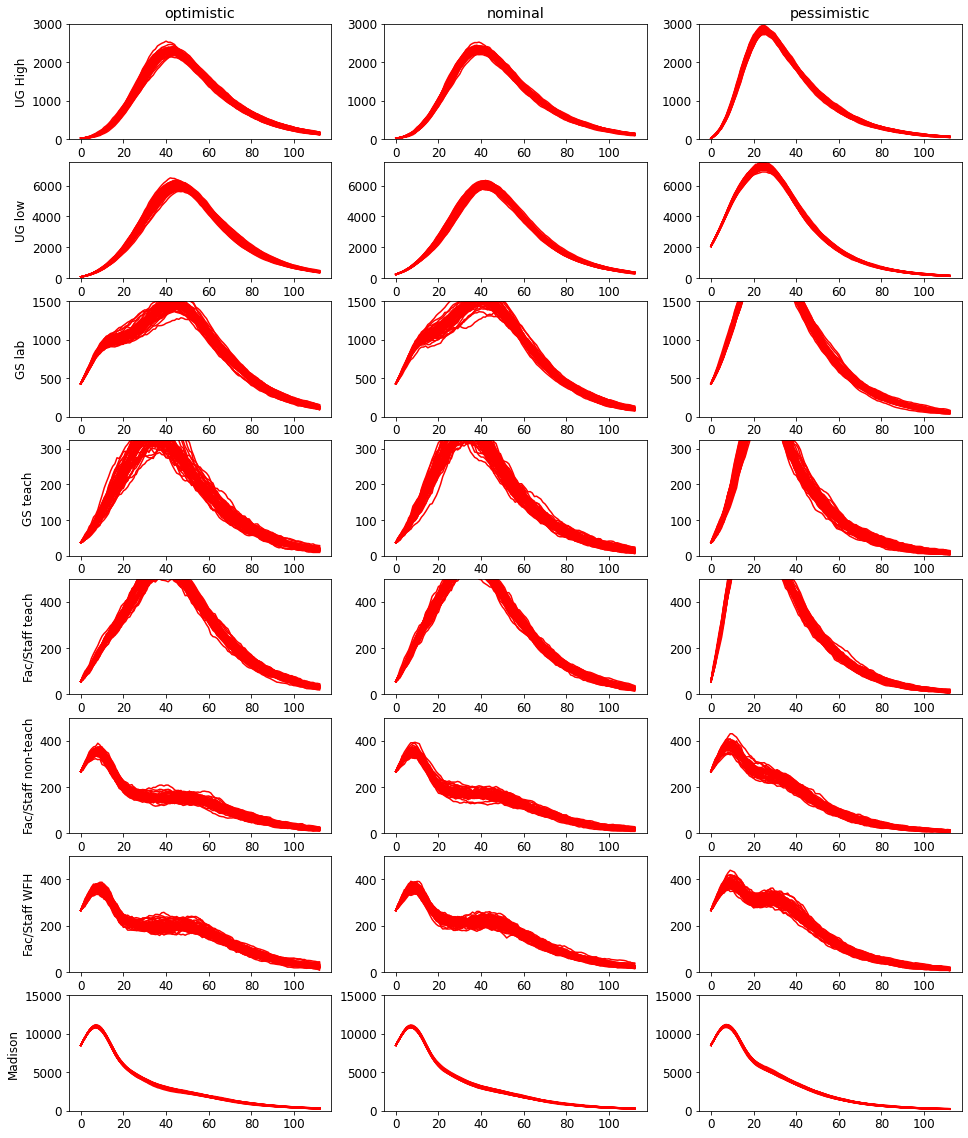

In [39]:
# Figuring out plotting w/ total active infections

scen_names = ['optimistic', 'nominal', 'pessimistic']
group_names = ['UG High', 'UG low', 'GS lab', 'GS teach', 'Fac/Staff teach', 'Fac/Staff non-teach', 'Fac/Staff WFH', 'Madison']
ylim_max = [3000, 7500, 1500, 325, 500, 500, 500, 15000]
fig, axs = plt.subplots(8, 3, figsize=(16,20))
# plt.ylim(0, 25000)

# fill w/ results
all_results = [sim_results_optimistic, sim_results_nominal, sim_results_pessimistic]
for scenario in range(3):
    for results in all_results[scenario]:
        for group in range(8):
            axs[group, scenario].set_ylim(0, ylim_max[group])
            axs[group, scenario].plot(results[group][active_cols].sum(axis=1), color='red')
            if group == 0:
                axs[group, scenario].set_title(scen_names[scenario])
            if scenario == 0:
                axs[group, scenario].set(ylabel=group_names[group])
                
# fig.suptitle('Total quarantined per group')

In [ ]:
sim_results_nominal[0][0].columns

In [ ]:
plt.plot(sim_results_nominal[0][0]['S'])

## visualizing interactions

In [68]:
from mpl_toolkits import mplot3d

In [69]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

ConversionError: Failed to convert value(s) to axis units: ['UG High', 'UG low', 'GS lab', 'GS teach', 'Fac/Staff teach', 'Fac/Staff non-teach', 'Fac/Staff WFH', 'Madison']

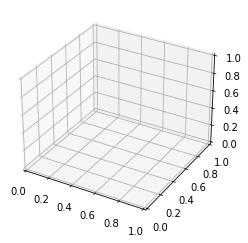

In [73]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xticks(group_names)
ax.set_yticks(group_names)

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('interaction lambdas');

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

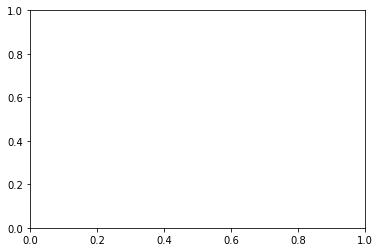

In [72]:
plt.xticks()

## Below from cornell
To evaluate steady state capacities?

In [ ]:
FP_isolation_nominal = student_tests_per_day * 14 * 0.001
isolation_student_nominal = list()
quarantine_student_nominal = list()
quarantine_ug_high_nominal = list()

for sim in sim_results_nominal:
    quarantine_ug_high_nominal.append(np.array(sim[0].tail(112-28)['QS'].tolist()) - (ug_high_tests_per_day * 14 * 0.001))

    quarantine_student = -1 * FP_isolation_nominal * (student_tests_per_day - ug_high_tests_per_day) / student_tests_per_day
    quarantine_student += np.array(sim[1].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[2].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[3].tail(112-28)['QS'].tolist())
    quarantine_student_nominal.append(quarantine_student)

    isolation_student = np.array(sim[0].tail(112-28)['QI'].tolist()) + FP_isolation_nominal
    isolation_student += np.array(sim[1].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[2].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[3].tail(112-28)['QI'].tolist())
    isolation_student_nominal.append(isolation_student)

isolation_student_nominal = np.concatenate(isolation_student_nominal)
quarantine_student_nominal = np.concatenate(quarantine_student_nominal)
quarantine_student_nominal[quarantine_student_nominal<0] = 0
quarantine_ug_high_nominal = np.concatenate(quarantine_ug_high_nominal)
FP_isolation_nominal, np.median(isolation_student_nominal), np.median(quarantine_student_nominal), np.median(quarantine_ug_high_nominal)

In [ ]:
FP_isolation_optimistic = student_tests_per_day * 14 * 0.001
isolation_student_optimistic = list()
quarantine_student_optimistic = list()
quarantine_ug_high_optimistic = list()

for sim in sim_results_optimistic:
    quarantine_ug_high_optimistic.append(np.array(sim[0].tail(112-28)['QS'].tolist()) - (ug_high_tests_per_day * 14 * 0.001))

    quarantine_student = -1 * FP_isolation_optimistic * (student_tests_per_day - ug_high_tests_per_day) / student_tests_per_day
    quarantine_student += np.array(sim[1].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[2].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[3].tail(112-28)['QS'].tolist())
    quarantine_student_optimistic.append(quarantine_student)

    isolation_student = np.array(sim[0].tail(112-28)['QI'].tolist()) + FP_isolation_optimistic
    isolation_student += np.array(sim[1].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[2].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[3].tail(112-28)['QI'].tolist())
    isolation_student_optimistic.append(isolation_student)

isolation_student_optimistic = np.concatenate(isolation_student_optimistic)
quarantine_student_optimistic = np.concatenate(quarantine_student_optimistic)
quarantine_student_optimistic[quarantine_student_optimistic<0] = 0
quarantine_ug_high_optimistic = np.concatenate(quarantine_ug_high_optimistic)
FP_isolation_optimistic, np.median(isolation_student_optimistic), np.median(quarantine_student_optimistic), np.median(quarantine_ug_high_optimistic)

In [ ]:
FP_isolation_pessimistic = student_tests_per_day * 14 * 0.001
isolation_student_pessimistic = list()
quarantine_student_pessimistic = list()
quarantine_ug_high_pessimistic = list()

for sim in sim_results_pessimistic:
    quarantine_ug_high_pessimistic.append(np.array(sim[0].tail(112-28)['QS'].tolist()) - (ug_high_tests_per_day * 14 * 0.001))

    quarantine_student = -1 * FP_isolation_pessimistic * (student_tests_per_day - ug_high_tests_per_day) / student_tests_per_day
    quarantine_student += np.array(sim[1].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[2].tail(112-28)['QS'].tolist())
    quarantine_student += np.array(sim[3].tail(112-28)['QS'].tolist())
    quarantine_student_pessimistic.append(quarantine_student)

    isolation_student = np.array(sim[0].tail(112-28)['QI'].tolist()) + FP_isolation_pessimistic
    isolation_student += np.array(sim[1].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[2].tail(112-28)['QI'].tolist())
    isolation_student += np.array(sim[3].tail(112-28)['QI'].tolist())
    isolation_student_pessimistic.append(isolation_student)

isolation_student_pessimistic = np.concatenate(isolation_student_pessimistic)
quarantine_student_pessimistic = np.concatenate(quarantine_student_pessimistic)
quarantine_student_pessimistic[quarantine_student_pessimistic<0] = 0
quarantine_ug_high_pessimistic = np.concatenate(quarantine_ug_high_pessimistic)
FP_isolation_pessimistic, np.median(isolation_student_pessimistic), np.median(quarantine_student_pessimistic), np.median(quarantine_ug_high_pessimistic)

In [ ]:
# np.array(sim_results_nominal[0][0].tail(112-28)['QS'].tolist()) + np.array(sim_results_nominal[0][1].tail(112-28)['QS'].tolist())
sim_results_nominal[0][0].tail(112-28)['cumulative_mild'].tolist()[-1]
# isolation_student_nominal.shape

## Making Distribution Graphs

## Isolations (all students)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

sns.distplot(isolation_student_optimistic, hist=False, rug=False, label='Optimistic')
sns.distplot(isolation_student_nominal, hist=False, rug=False, label='Nominal')
sns.distplot(isolation_student_pessimistic, hist=False, rug=False, label='Pessimistic')
plt.title('Distribution of Steady-state Isolations across all students')
plt.xlabel('Number of Isolated Students')
plt.show()

## Quarantines for UG High only

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

sns.distplot(quarantine_ug_high_optimistic, hist=False, rug=False, label='Optimistic')
sns.distplot(quarantine_ug_high_nominal, hist=False, rug=False, label='Nominal')
sns.distplot(quarantine_ug_high_pessimistic, hist=False, rug=False, label='Pessimistic')
plt.title('Distribution of Steady-state Quarantines for Undergrads in Dorms, Fraternaties and Sororities')
plt.xlabel('Number of Quarantined Students')
plt.show()

## Quarantines for all other students

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

sns.distplot(quarantine_student_optimistic, hist=False, rug=False, label='Optimistic')
sns.distplot(quarantine_student_nominal, hist=False, rug=False, label='Nominal')
sns.distplot(quarantine_student_pessimistic, hist=False, rug=False, label='Pessimistic')
plt.title('Distribution of Steady-state Quarantines for all other students')
plt.xlabel('Number of Quarantined Students')
plt.show()

In [ ]:
# np.mean(isolation_student_optimistic), np.mean(isolation_student_nominal), np.mean(isolation_student_pessimistic)
# np.mean(quarantine_ug_high_optimistic), np.mean(quarantine_ug_high_nominal), np.mean(quarantine_ug_high_pessimistic)
np.mean(quarantine_student_optimistic), np.mean(quarantine_student_nominal), np.mean(quarantine_student_pessimistic)

In [ ]:
# np.quantile(isolation_student_optimistic, 0.9), np.quantile(isolation_student_nominal, 0.9), np.quantile(isolation_student_pessimistic, 0.9)
# np.quantile(quarantine_ug_high_optimistic, 0.9), np.quantile(quarantine_ug_high_nominal, 0.9), np.quantile(quarantine_ug_high_pessimistic, 0.9)
np.quantile(quarantine_student_optimistic, 0.9), np.quantile(quarantine_student_nominal, 0.9), np.quantile(quarantine_student_pessimistic, 0.9)

In [ ]:
# Pessimistic Total Infections
total_infections = list()
for sim in sim_results_pessimistic:
    scenario_total_infections = 0
    for i in range(7):
        scenario_total_infections += sim[i]['cumulative_mild'].tolist()[-1] + sim[i]['cumulative_severe'].tolist()[-1]
    total_infections.append(scenario_total_infections)
total_infections

In [ ]:
np.min(total_infections), np.max(total_infections)
FP_isolation_optimistic